In [1]:
#Import a bunch of Libraries and define some nice functions
import sklearn as skl
import pandas as pd
import numpy as np
import seaborn as sms
from scipy import stats
import matplotlib.pyplot as plt
import re
import pickle

import os
from scipy.stats import zscore
from nilearn import datasets,image,masking,signal,plotting,input_data
from natsort import natsorted 
from IPython.core.display import HTML
def multi_table(table_list):
    return HTML(
    '<table><tr style="background-color:white;">'+
    ''.join(['<td>'+table._repr_html_()+'</td>' for table in table_list])+
    '</tr></table>'
    )
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov

def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

from patsy.contrasts import ContrastMatrix

def _name_levels(prefix, levels):
    return ["[%s%s]" % (prefix, level) for level in levels]

class Simple(object):
    def _simple_contrast(self, levels):
        nlevels = len(levels)
        contr = -1./nlevels * np.ones((nlevels, nlevels-1))
        contr[1:][np.diag_indices(nlevels-1)] = (nlevels-1.)/nlevels
        return contr

    def code_with_intercept(self, levels):
        contrast = np.column_stack((np.ones(len(levels)),
                                    self._simple_contrast(levels)))
        return ContrastMatrix(contrast, _name_levels("Simp.", levels))

    def code_without_intercept(self, levels):
        contrast = self._simple_contrast(levels)
        return ContrastMatrix(contrast, _name_levels("Simp.", levels[:-1]))



/home/strange/.local/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
#Import Subject Data and ICA outputfiles
sub_data=pd.read_csv('Post-Melodic/Exp1/all_DesignMatrix.csv',index_col=0)
sub_data['Subject'] = 'sub-' + sub_data['Subject'].astype('int').astype('str')
Melodic_Outs=natsorted([os.path.join(root,d) for root,dirs,files in
                        os.walk('Post-Melodic/Exp1') for d in dirs if ((d.startswith('tica')) & (d.endswith('.ica')))])
display(Melodic_Outs)

['Post-Melodic/Exp1/tica_20dim_task-Gam_LindseySubs_sm-2_merged_z.ica',
 'Post-Melodic/Exp1/tica_20dim_task-Soc_LindseySubs_sm-2_merged_z.ica',
 'Post-Melodic/Exp1/tica_70dim_task-Gam_LindseySubs_sm-2_merged_z.ica',
 'Post-Melodic/Exp1/tica_70dim_task-Soc_LindseySubs_sm-2_merged_z.ica']

In [3]:
#Make the 3 nilearn images for masks
from nilearn import image,datasets,masking,plotting,input_data
import matplotlib.pyplot as plt

HO_sub=datasets.fetch_atlas_harvard_oxford(atlas_name='sub-maxprob-thr50-2mm')
keep = [idx for idx, s in enumerate(HO_sub.labels) if
        'White' in s or 'Ventricle' in s or 'Ventrical' in s or '']
display(keep)
noise_regions=image.concat_imgs(np.array(
    [image.math_img("img==1", img=HO_sub.maps),image.math_img("img==3", img=HO_sub.maps),
     image.math_img("img==12", img=HO_sub.maps),image.math_img("img==14", img=HO_sub.maps)]))
                                 
str_regions=image.concat_imgs(np.array(
    [image.math_img("img==5", img=HO_sub.maps),image.math_img("img==6",img=HO_sub.maps),
     image.math_img("img==7", img=HO_sub.maps),image.math_img("img==11", img=HO_sub.maps),
     image.math_img("img==16", img=HO_sub.maps),image.math_img("img==17", img=HO_sub.maps),
     image.math_img("img==18", img=HO_sub.maps),image.math_img("img==22", img=HO_sub.maps)]))


WM_mask=masking.compute_background_mask(image.index_img(noise_regions,[0,2]))
Vent_mask=masking.compute_background_mask(image.index_img(noise_regions,[1,3]))
str_mask=masking.compute_background_mask(str_regions)

[1, 3, 12, 14]

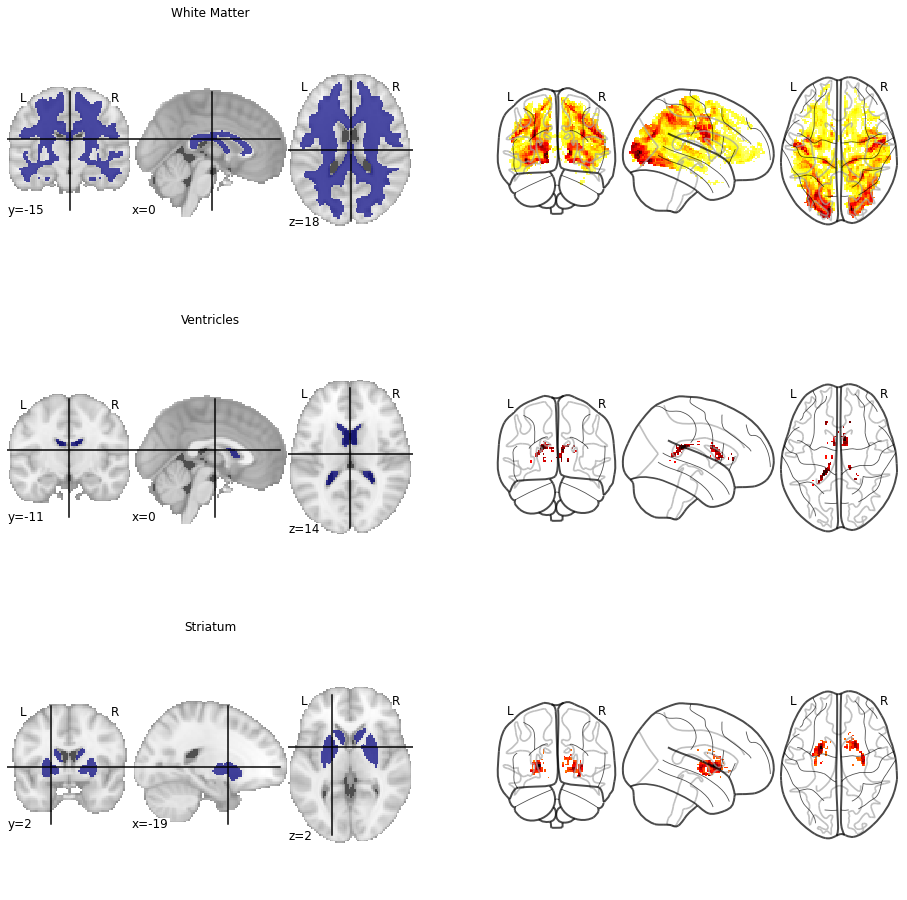

In [4]:
#Mask Figures to show areas Included
if 1==1:
    fig, axs = plt.subplots(3, 2,figsize=(16, 16))
    IC_image=image.load_img(Melodic_Outs[0]+'/stats/thresh_zstat1.nii.gz')

    plotting.plot_roi(WM_mask,axes=axs[0][0])
    plotting.plot_roi(Vent_mask,axes=axs[1][0])
    plotting.plot_roi(str_mask,axes=axs[2][0])
    axs[0][0].set_title('White Matter')
    axs[1][0].set_title('Ventricles')
    axs[2][0].set_title('Striatum')

    wm_masker=input_data.NiftiMasker(mask_img=WM_mask)
    maskImage=wm_masker.fit_transform(IC_image)
    plotting.plot_glass_brain(wm_masker.inverse_transform(maskImage),axes=axs[0][1])

    vent_masker=input_data.NiftiMasker(mask_img=Vent_mask)
    maskImage=vent_masker.fit_transform(IC_image)
    plotting.plot_glass_brain(vent_masker.inverse_transform(maskImage),axes=axs[1][1])

    str_masker=input_data.NiftiMasker(mask_img=str_mask)
    maskImage=str_masker.fit_transform(IC_image)
    plotting.plot_glass_brain(str_masker.inverse_transform(maskImage),axes=axs[2][1])

In [5]:
# Find Percent of above threshold voxels for White Matter, Ventricles, and Striatum for each IC
# Import Manually Classified IC's
man_class=[]
for file in [file for file in os.listdir('.') if ((file.startswith('Manual')&(file.endswith('.csv'))))]:
    print(file)
    t=pd.read_csv(file)
    t.rename(columns = {"Component": "IC"},  
          inplace = True) 
    #t['file']=(re.search('(.*)_noCov.csv' ,file).group(1))
    task=re.search('task-(.*?).csv',file).group(1)
    ds='tica_00dim_task-%s_LindseySubs_unsmoothed_merged_z.ica'%(task)
    
    f_list=natsorted([ ds+'/stats/'+f for f in os.listdir(ds+'/stats') if f.startswith('thresh')])
    
    
    row=[]
    for i,f in enumerate(f_list):
        IC='IC%02d'%(int(re.search('zstat(.*).nii',f).group(1)))
        p_map=ds+'/stats/probmap_%s.nii.gz'%(int(re.search('zstat(.*).nii',f).group(1)))
        #row.append([ds,task,run,IC,f,p_map])

        #print(f,IC)
        wm=wm_masker.fit_transform(f)
        vent=vent_masker.fit_transform(f)
        str_=str_masker.fit_transform(f)
        row.append([ds,task,IC,f,p_map,
        np.divide(np.count_nonzero(np.where(np.absolute(wm)>1)),wm.shape[1]),
        np.divide(np.count_nonzero(np.where(np.absolute(vent)>1)),vent.shape[1]),
        np.divide(np.count_nonzero(np.where(np.absolute(str_)>1)),str_.shape[1])])
        
    IC_df=pd.DataFrame(columns=['directory','task','run','IC','file','prob_map','WhiteMatter','Ventricle','Striatum'],data=row)
    #IC_df=pd.DataFrame(columns=['directory','task','run','IC','file','prob_map'],data=row)
    display(IC_df.head())
    t=t.merge(IC_df, on='IC')
    man_class.append(t)
    
man_class=pd.concat(man_class)
man_class.reset_index(drop=True,inplace=True)
man_class['One_IsGood']=man_class['J_IsGood']+man_class['D_IsGood']>0


#test=IC_df[(IC_df['Striatum']>IC_df['Ventricle'])&(IC_df['Striatum']>IC_df['WhiteMatter'])|(IC_df['IC'].apply(str).str.contains('40'))]


ValueError: No objects to concatenate

In [ ]:
from nilearn.plotting import plot_prob_atlas
from nilearn import image
import matplotlib.pyplot as plt
import nibabel as nib

mask=image.load_img("%s/mask.nii.gz"%(Melodic_Outs[0]))
#plotting.plot_roi(mask)

mask=input_data.NiftiMasker(mask_img=masking.compute_background_mask(mask))



for task in man_class['task'].unique():
    for run in man_class['run'].unique():
        display(task,run)
        df=man_class[(man_class['task']==task) & (man_class['run']==run) & (man_class['Both Agree']==True)]
        #plot_prob_atlas(df['prob_map'],cut_coords=[0,5,5],threshold=0.999,draw_cross=False)
        #plt.show()
        img_list=mask.fit_transform(df['prob_map'])
        img_abs=np.sum(np.absolute(img_list)>0.95,axis=0)
        nib.save(mask.inverse_transform(img_abs),"Overlap_task-%s_run-%s.nii.gz"%(task,run))
        display(plotting.view_img(mask.inverse_transform(img_abs),
                          threshold=2, title="Overlap",draw_cross=False,cmap='gist_ncar',symmetric_cmap=False))


In [ ]:
for results in man_class.directory.unique():
    print(results)
    good_ICS=man_class[(man_class['directory']==results)&(man_class['Both Agree']==True)]['IC']
    log_file = open(results+'/log.txt', 'r') 
    Lines = log_file.readlines()
    log_file.close()
    
    task=re.search('task-(.*)_r',results).group(1)
    run=re.search('run-(.*)_L',results).group(1)
    
    subs=[]
    for line in Lines:
        if line.startswith("Excluding voxels with constant value"):
            break
        elif line.startswith("Reading data file"):
            subs.append('sub-'+re.search('sub-(.*)_task',line).group(1))
            
    smodes=pd.read_csv(results+'/melodic_Smodes',
                       delim_whitespace=True,header=None)

    colnames=['IC%02d'%(i+1) for i,col in enumerate(smodes.columns)]
    smodes.columns=colnames
    smodes=smodes[good_ICS]
    
    smodes['Subject']=subs
    smodes.to_csv('ForPalm_task-%s_run-%s.csv'%(task,run))

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from patsy.contrasts import Poly

sms.set_theme(style="whitegrid")

for results in man_class.directory.unique():
    good_ICS=man_class[(man_class['directory']==results)&(man_class['Both Agree']==True)]['IC']

    print(results)
    log_file = open(results+'/log.txt', 'r') 
    Lines = log_file.readlines()
    log_file.close()
    
    task=re.search('task-(.*)_r',results).group(1)
    run=re.search('run-(.*)_L',results).group(1)
    
    subs=[]
    for line in Lines:
        if line.startswith("Excluding voxels with constant value"):
            break
        elif line.startswith("Reading data file"):
            subs.append('sub-'+re.search('sub-(.*)_task',line).group(1))
            
    smodes=pd.read_csv(results+'/melodic_Smodes',
                       delim_whitespace=True,header=None)

    colnames=['IC%02d'%(i+1) for i,col in enumerate(smodes.columns)]
    smodes.columns=colnames
    smodes=smodes[good_ICS]
    smodes['Subject']=subs

    #smodes.to_csv('ForPalm_task-%s_run-%s.csv'%(task,run))
    smodes=pd.merge(smodes, sub_data, on='Subject')
    #smodes=pd.merge(smodes, s_ab, on='Subject')
    smodes['groups']=smodes[['Dep','FamHist','HC']].idxmax(axis=1)
    smodes.rename(columns = {'40K_demeaned':'delay'}, inplace = True)
    for var in['Dep_Sx_demeaned','Sadness_demeaned','Drinks_demeaned', 'Tobacco_demeaned']:
        smodes["log_%s"%(var)]=np.sqrt(smodes["%s"%(var)])

    
    Adj_p=np.divide(0.05,len(man_class[(man_class['Both Agree']==True)&(man_class['directory']==results)]))
    print("Adjusted alpha: %s"%Adj_p)
                                        
    for IC in colnames:
        if man_class[(man_class['IC']==IC)&(man_class['directory']==results)]['Both Agree'].values[0]:
            
            levels = smodes.groups.unique().tolist()
            contrast = Poly().code_without_intercept(levels)
            
            res = smodes.groupby("groups")[IC].quantile([.25, .75]).unstack(level=1)
            res['IQR']=res.iloc[:,1]-res.iloc[:,0]
            res['3_IQR']=res['IQR']*1.5
            res['mean']=smodes.groupby("groups")[IC].mean()
            res['upper']=res['mean']+res['3_IQR']
            res['lower']=res['mean']-res['3_IQR']

            smodes=smodes.loc[((res.loc[smodes.groups, 'lower'] < smodes[IC].values)
                        & (smodes[IC].values < res.loc[smodes.groups, 'upper'])).values]
            
            mod = ols('%s ~ groups'%(IC),data=smodes).fit()
            
            #aov_table = sm.stats.anova_lm(mod, typ=2)

            if mod.f_pvalue<0.05:
                print(results)
                #display(mod.summary2())
                #aov_table = sm.stats.anova_lm(mod, typ=2)
                display(aov_table)
                pair_t = mod.t_test_pairwise('groups')
                display(pair_t.result_frame)
                #Plot
                dirname='%s_%s_%s'%(task,run,IC)
                os.makedirs(dirname,exist_ok=True)
                sms.barplot(x='groups',y=IC,data=smodes,ci=68,capsize=.05,
                            order=['Dep','FamHist','HC'],palette="PuBuGn_d")
                plt.savefig(dirname+'/%s_groups.svg'%(IC))
                plt.show()

                #fig, axs = plt.subplots(2, 2,figsize=(16, 16))

                #for i,var in enumerate(['Dep_Sx_demeaned','Sadness_demeaned','delay',
                                        #'Drinks_demeaned', 'Tobacco_demeaned']):
                    #sms.lmplot(x=var,y=IC,data=smodes)
                    #plt.savefig(dirname+'/%s_%s.svg'%(IC,var))                    
                    #plt.show()
                    
                    #mod = ols('%s ~ %s'%(IC,var),data=smodes[smodes['groups']=='Dep']).fit()
                    #if mod.pvalues[var]<0.05:
                        #display(mod.summary())
                #for i,var in enumerate(['Drinks_demeaned', 'Tobacco_demeaned']):
                    #ms.regplot(x=var,y=IC,data=smodes_plot,ax=axs[1][i])

                #plt.show()

In [ ]:

for task in man_class['task'].unique():
    for run in man_class['run'].unique():
        display(task,run)
        df=man_class[(man_class['task']==task) & (man_class['run']==run) &
                     (man_class['IC'].isin(['IC02','IC03','IC05','IC06','IC07']))]
        #plot_prob_atlas(df['prob_map'],cut_coords=[0,5,5],threshold=0.999,draw_cross=False)
        #plt.show()
        img_list=mask.fit_transform(df['prob_map'])
        img_abs=np.sum(np.absolute(img_list)>0.95,axis=0)
        nib.save(mask.inverse_transform(img_abs),"Overlap_task-%s_run-%s.nii.gz"%(task,run))
        display(plotting.view_img(mask.inverse_transform(img_abs),
                          threshold=2, title="Overlap",draw_cross=False,cmap='gist_ncar',symmetric_cmap=False))


In [ ]:
for results in man_class.directory.unique():
    good_ICS=man_class[(man_class['directory']==results)&(man_class['Both Agree']==True)]['IC']
    
    design=pd.read_csv('L1_task-Gam_run-RL_design.mat',skiprows=5,sep='\t',
                   header=None,names=['Gains','Losses','DropThis'])
    design=design[['Gains','Losses']]

In [ ]:
from scipy.stats import zscore
task='Gam'
run='RL'

design=pd.read_csv('L1_task-%s_run-%s_design.mat'%(task,run),skiprows=5,sep='\t',
                   header=None,names=['Gains','Losses','DropThis'])
design=design[['Gains','Losses']]
#read the participants csv file so you know what group they were in and demographics
sub_data['groups']=sub_data[['Dep','FamHist','HC']].idxmax(axis=1)

df_list=[]

for row in sub_data.iterrows():
    #display(row[1])
    tdf=design
    tdf['sub']=row[1]['Subject']
    tdf['group']=row[1]['groups']
    df_list.append(tdf.copy())
   
df=pd.concat(df_list).reset_index(drop=True)
data_dir='tica_00dim_task-%s_run-%s_LindseySubs_wDesigns_new_unsmoothed.ica/report/'%(task,run)
files=[data_dir+f for f in os.listdir(data_dir) if f.startswith('t') if f.endswith('.txt')]

for f in natsorted(files):

    Tweight_df=pd.read_csv(f,delim_whitespace=True,
                           header=None,names=subs)
    #display(Tweight_df)
    Tweight_df.reset_index(drop=True,inplace=True)
    #display(Tweight_df.mean(axis=1))
    
    Zweight_df=Tweight_df.apply(zscore)
    
    df["IC%02d"%(int(re.search('report/t(.*).txt',f).group(1)))]=Zweight_df.melt()['value']

In [ ]:
from statsmodels.formula.api import ols,mixedlm,gls
from statsmodels.stats.anova import anova_lm
import statsmodels
from mpl_toolkits.mplot3d import Axes3D
import natsort

data=[]
good_ICS=man_class[(man_class['Both Agree']==True)&
    (man_class[
        'directory']=='tica_00dim_task-%s_run-%s_LindseySubs_wDesigns_new_unsmoothed.ica'%(
    task,run))]['IC']
#for IC in IC_df[(IC_df['Striatum']>IC_df['Ventricle'])& (IC_df['Striatum']>IC_df['WhiteMatter'])|(IC_df['IC'].apply(str).str.contains('40'))].IC:
for IC in [IC for IC in good_ICS]:
    
    row=[]
    for sub in natsorted(df['sub'].unique()):
        e1="%s ~ Gains + Losses"%(IC)
        t_df=df[df['sub']==sub]
        model1 = ols(e1, t_df).fit()

        row.append([sub,t_df.group.unique()[0],
                    IC,model1.params['Gains'],model1.params['Losses']])
    
    row=np.array(row)
    
    data.append(row)

In [ ]:

reg_df=pd.DataFrame(columns=['sub','group','IC','Gains','Losses'],
                    data=np.concatenate(data))
reg_df['Gains']=pd.to_numeric(reg_df['Gains'])
reg_df['Losses']=pd.to_numeric(reg_df['Losses'])

reg_df['Diff']=reg_df['Gains']-reg_df['Losses']
#reg_df=pd.melt(reg_df, id_vars=['sub','group','IC'], value_vars=['Gains','Losses','Diff'])
#reg_df['value']=pd.to_numeric(reg_df['value'])
reg_df.head()

pivot_df=reg_df[['sub','IC','Diff']]
pivot_df=pivot_df.pivot('sub','IC')
pivot_df.to_csv('Fit_T_beta_diff_task-%s_run-%s.csv'%(task,run))

In [ ]:
plot_df=reg_df[reg_df['variable']!='Diff'].copy()
sms.set_theme(style="whitegrid")

for IC in reg_df.IC.unique():
    print(IC)
    tdf=plot_df[plot_df['IC']==IC]
    model = ols('value ~ C(group)',
                data=tdf).fit()
    #display(model.summary())
    display(sm.stats.anova_lm(model, typ=1))    
    

    #sms.barplot(x='group', y='value', hue='variable',ci=68,
                #data=plot_df[plot_df['IC']==IC])
    g = sms.catplot(x="variable", y="value", hue="group", 
                capsize=.2,hue_order=['Dep','FamHist','HC'],palette="PuBuGn_d", height=6, aspect=.75,
                kind="point", data=tdf)
    plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)
    plt.savefig('Gain_Loss_%s.svg'%(IC))
    plt.show()


In [ ]:
for group in reg_df.group.unique():
        print(group)
        ttdf=tdf[tdf['group']==group]
        mod = ols('value ~ variable',data=ttdf).fit()
        pair_t = mod.t_test_pairwise('variable')
        display(pair_t.result_frame)

In [ ]:
plot_df.head()

In [ ]:
from scipy.stats import ttest_rel
ttdf=tdf[tdf['group']=='Dep']
# Python paired sample t-test
ttest_rel(ttdf[ttdf['variable']=='Gains'].value, 
         ttdf[ttdf['variable']=='Losses'].value)